# Version information

In [236]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)


Running date: July 06, 2022
Pyleecan version:1.3.9
SciDataTool version:2.4.9


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

z:\01_codes_projects\pyleecan_fork\pyleecan\Methods\Machine\Machine\plot.py:190: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.00193

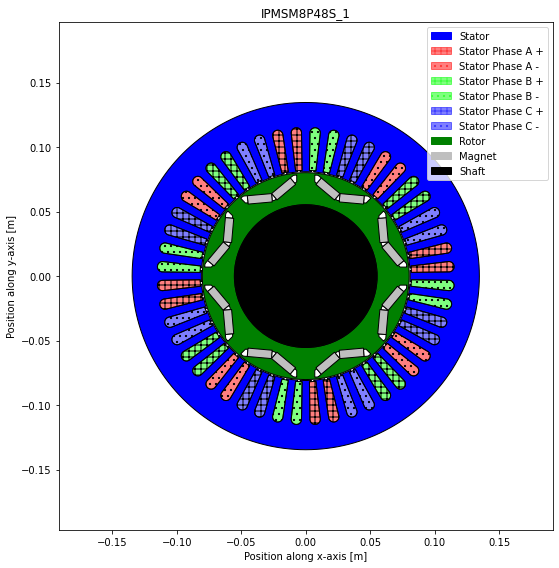

In [237]:
%matplotlib inline

# Load the machine
from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

# 힘 계산 클래스 추가
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.definitions import DATA_DIR


from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D 

# print(DATA_DIR)

path = 'D:/NGV/Lecture_Simu_Model'
modelname = 'IPMSM8P48S1'
model = join(modelname+'.json')

# Load machine
Toyota_Prius = load(join(path,model))
Toyota_Prius.plot()
save_path='D:/NGV/result_parasweep'
Toyota_Prius.stator.slot.W0

In [250]:
import numpy as np
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportGenVectSin import ImportGenVectSin
from pyleecan.Classes.ImportGenMatrixSin import ImportGenMatrixSin
ref_simu = Simu1(name="test_slot_scale", machine=Toyota_Prius)

# # Definition of the enforced output of the electrical module
# Is_mat = zeros((1, 3))
# Is_mat[0, :] = np.array([0, 12.2474, -12.2474])
# Is = ImportMatrixVal(value=Is_mat)
# time = ImportGenVectLin(start=0, stop=0, num=1, endpoint=False)
# Na_tot = 2048

## Simu 1 Simulation (No-load)

In [251]:
from numpy import sqrt, pi
ref_simu.input = InputCurrent()
ref_simu.input.Nt_tot = 128 # Number of time step
ref_simu.input.Na_tot = 2048 # Spatial discretization
# Set reference simulation operating point
ref_simu.input.OP = OPdq(N0 = 2000) # Rotor speed [rpm]
ref_simu.input.OP.Tem_av_ref = 353
ref_simu.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)


# Definition of the magnetic simulation
ref_simu.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    Kgeo_fineness=0.2,
    Kmesh_fineness=0.2,
    nb_worker=8,
)
ref_simu.force=ForceMT(  is_periodicity_a=True,is_periodicity_t=True,)

In [241]:
# result=ref_simu.run()

[21:42:28] Starting running simulation test_slot_scale (machine=IPMSM8P48S_1)
[21:42:28] Starting Magnetic module
[21:42:29] Computing Airgap Flux in FEMM
[21:42:34] Starting Force module
[21:42:34] End of simulation test_slot_scale


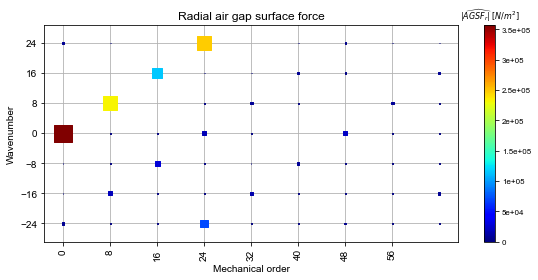

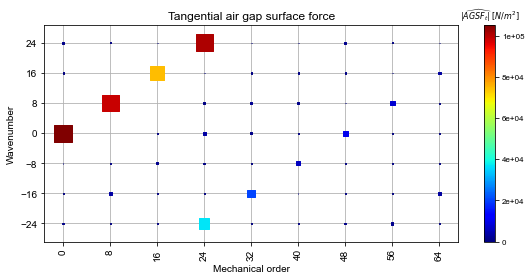

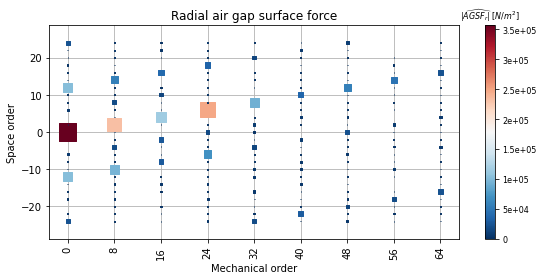

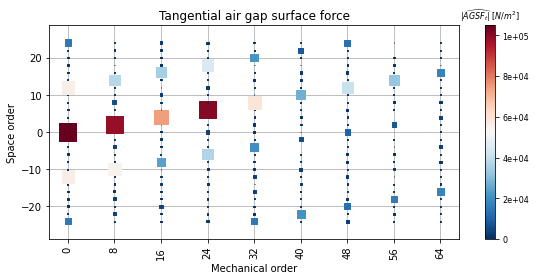

In [252]:
# 접선방향 전체 파형 2D (Mech_order / wavenumber)
AGSF_load=result.force.AGSF
# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-25,25]",
    N_stem=100,
    is_2D_view=True,
    **dict_3D
)


In [253]:
from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerSet import ParamExplorerSet
from pyleecan.Classes.DataKeeper import DataKeeper
multisim = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
)
ref_simu.var_simu = multisim

In [254]:
from numpy import pi, ones, zeros, linspace
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

# paramexplorer_list = [
#     ParamExplorerSet(
#         name="Stator slot scale factor",
#         symbol="stat_slot",
#         unit="",
#         setter=simu.machine.stator.slot.W0,
#         value=linspace(0.1, 1.1, 11).tolist(),
#     )
# ]

paramexplorer_list=[ParamExplorerInterval(
    name="Stator slot opening",
    symbol="W0s",
    unit="m",
    setter="simu.machine.stator.slot.W0",
    getter="simu.machine.stator.slot.W0",
    min_value=0.1 * Toyota_Prius.stator.slot.W0,
    max_value=1.4 * Toyota_Prius.stator.slot.W0,
    N=14,
)
]

In [255]:
multisim.paramexplorer_list = paramexplorer_list
error_keeper_mag_flux = "lambda simu: np.nan * np.zeros(len(simu.mag.B.Time.get_values()), len(simu.mag.B.Angle.get_values()))"

## Simu2 simulation (Load) w parameter sweep & 2 OP point


In [256]:

datakeeper_list = [
    DataKeeper(
        name="Average Torque",
        unit="N.m",
        symbol="Tem_av",
        keeper="lambda output: output.mag.Tem_av",
        error_keeper="lambda simu: np.nan",
    ),
    DataKeeper(
        name="Radial Airgap flux density",
        unit="H",
        symbol="B",
        keeper="lambda output: output.mag.B.components['radial'].get_along('time','angle')['B_{rad}']",
        error_keeper=error_keeper_mag_flux,
    ),
    DataKeeper(
        name="0th_6f Harmonic",
        unit="N.m^2",
        symbol="r06fs",
        keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6','wavenumber=0')['AGSF_r']",
        error_keeper="lambda simu: np.nan",
    ),
    DataKeeper(
        name="0th_12f Harmonic",
        unit="N.m^2",
        symbol="r012fs",
        keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=12','wavenumber=0')['AGSF_r']",
        error_keeper="lambda simu: np.nan",
    ),
    DataKeeper(
        name="24th_6f Harmonic",
        unit="N.m^2",
        symbol="r24_6fs",
        keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->mech_order=24','wavenumber=24')['AGSF_r']",
        error_keeper="lambda simu: np.nan",
    ),
    DataKeeper(
        name="n24th_6f Harmonic",
        unit="N.m^2",
        symbol="rn24_6fs",
        keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->mech_order=24','wavenumber=-24')['AGSF_r']",
        error_keeper="lambda simu: np.nan",
    ),
    DataKeeper(
        name="stator Slot",
        unit="",
        symbol="W0s",
        keeper="lambda output: output.simu.machine.stator.slot.W0",
        error_keeper="lambda simu: np.nan",
    ),
]


In [257]:
multisim.datakeeper_list = datakeeper_list

# Execute every simulation
results = ref_simu.run()


[21:47:42] Starting running simulation test_slot_scale (machine=IPMSM8P48S_1)
[21:47:42] Computing reference simulation for Parameter Sweep
[21:47:42] W0s: 14 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[21:47:42] Starting Magnetic module
[21:47:44] Computing Airgap Flux in FEMM
[21:47:47] Starting Force module
[21:47:47] Parameter Sweep Reference Results: Tem_av=359.6 [N.m], B=array(min=-1.923,max=1.923) [H], r06fs=array(min=1.729e+04,max=1.729e+04) [N.m^2], r012fs=array(min=2.191e+04,max=2.191e+04) [N.m^2], r24_6fs=array(min=2.473e+05,max=2.473e+05) [N.m^2], rn24_6fs=array(min=7.033e+04,max=7.033e+04) [N.m^2], W0s=0.00193 [], N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_rip_pp=83.24 [N.m], Tem_rip_norm=0.2315 [-], Pem_av=7.531e+04 [W]
[===                                               ]   6%
[21:47:48] Running simulation 1/14 with W0s=0.000193
[21:47:48] Starting Magnetic module
[21:47:51] Computing Airgap Flux in FEMM
[21:47:53] Starting Force module
[21:47:53] Param

14 14
[1, 1, 6.369000000000003e-06, 8.492000000000003e-06, 1.0615000000000004e-05, 1.2738000000000004e-05, 1.4861000000000006e-05, 1.6984000000000005e-05, 1.9107000000000005e-05, 2.1230000000000005e-05, 2.3353000000000005e-05, 2.5476000000000008e-05, 2.7599000000000008e-05, 1]


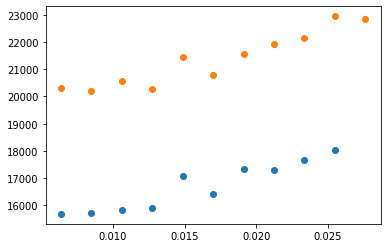

In [267]:
import matplotlib.pyplot as plt
import math
# print(results.xoutput_dict['W0s'])
W0s=results.xoutput_dict['W0s'].result
tav=results.xoutput_dict['Tem_av'].result
sixfs=results.xoutput_dict['r06fs'].result
twfs=results.xoutput_dict['r012fs'].result
r246fs=results.xoutput_dict['r24_6fs'].result
# type(W0s[11])
print(len(W1s),len(sixfs))
# # len
for i in 1,1,len(W0s)-1:
    W1s[i]=math.ceil(W0s[i])

print(W1s)
W0s=np.array((W1s))
W0=W0s/0.001 # [m] to [mm] unit

# zero-th wavenumber
plt.scatter(W0[2:12],sixfs[2:12])
plt.scatter(W0[2:13],twfs[2:13])


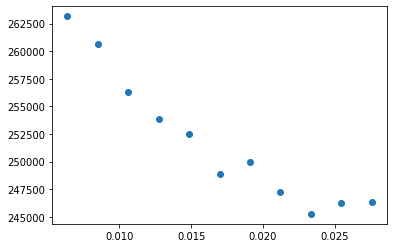

In [268]:
plt.scatter(W0[2:13],r246fs[2:13])

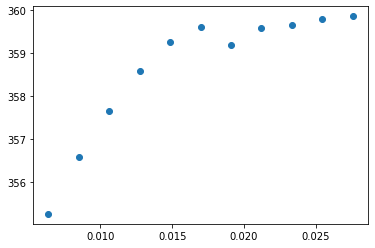

In [269]:
plt.scatter(W0[2:13],tav[2:13])

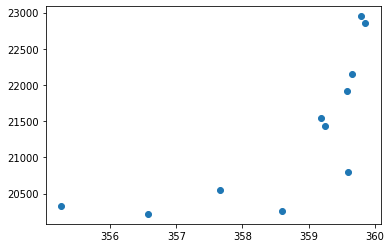

In [272]:
# plt.scatter(tav[2:13],r246fs[2:13])
plt.scatter(tav[2:13],twfs[2:13])

In [281]:
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
ref_simu.var_simu = sweep
N_sweep = 8
ref_simu.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=N_sweep,
    )
]

In [283]:
Xout_sweep = ref_simu.run()

[22:05:39] Starting running simulation test_slot_scale (machine=IPMSM8P48S_1)
[22:05:39] Computing reference simulation for Parameter Sweep
[22:05:39] W0s: 8 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[22:05:39] Starting Magnetic module
[22:05:40] Computing Airgap Flux in FEMM
[22:05:45] Starting Force module
[22:05:45] Parameter Sweep Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=359.6 [N.m], Tem_rip_pp=83.24 [N.m], Tem_rip_norm=0.2315 [-], Pem_av=7.531e+04 [W]
[=====                                             ]  11%
[22:05:45] Running simulation 1/8 with W0s=0.000193
[22:05:45] Starting Magnetic module
[22:05:46] Computing Airgap Flux in FEMM
[22:05:50] Starting Force module
[22:05:50] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=351.8 [N.m], Tem_rip_pp=92.7 [N.m], Tem_rip_norm=0.2635 [-], Pem_av=7.369e+04 [W]
[===========                                       ]  22%
[22:05:50] Running simulation 2/8 with W0s

[351.84337021945214, 355.372275703603, 357.40968941317215, 358.7249008778982, 359.7550074101837, 359.62651193345846, 359.5953463832485, 359.8664669796591]
[0.00019300000000000003, 0.0005514285714285714, 0.0009098571428571429, 0.0012682857142857144, 0.0016267142857142858, 0.001985142857142857, 0.002343571428571429, 0.002702]
8


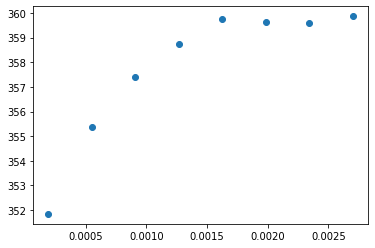

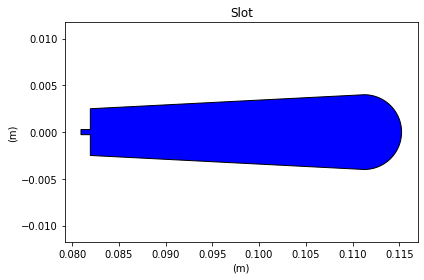

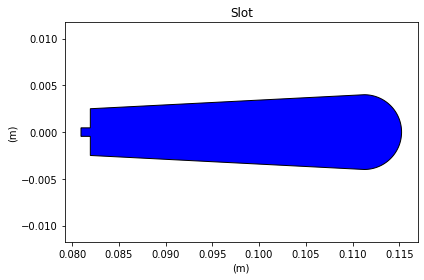

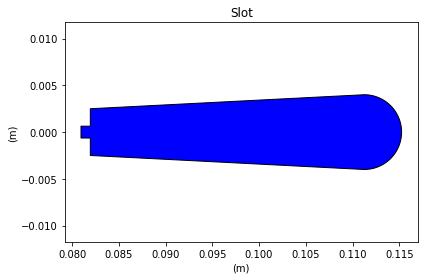

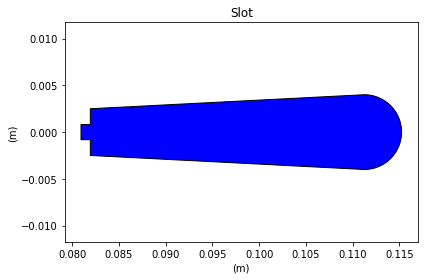

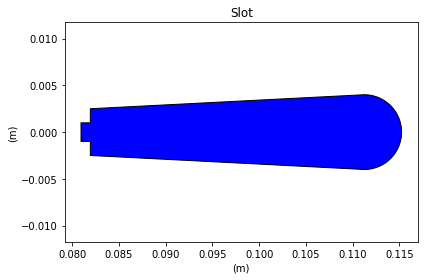

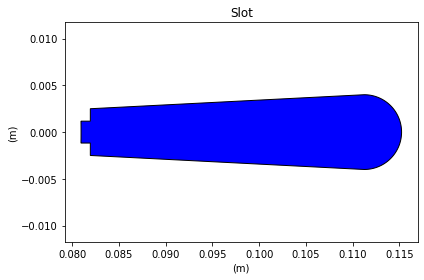

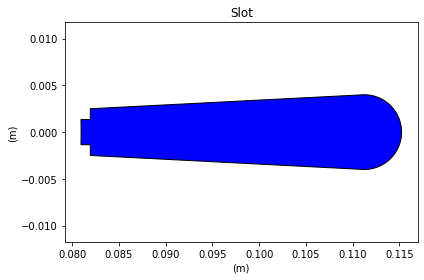

In [367]:
# 
Tem = (results.xoutput_dict["Tem_av"].result)
print(Tem)
W0s_val = results.paramexplorer_list[0].get_value()
print(W0s_val)
plt.scatter(W0s_val,Tem)
print(N_sweep)


for i in range(1,N_sweep):
    results.output_list[i].simu.machine.stator.slot.plot()
    